<p> Code found <a href="https://www.youtube.com/watch?v=M2PqI2JD2jo&feature=youtu.be">on the internet</a>.</p>

In [1]:
#Well... Numerics, Linear Algebra and Plotting
from numpy import *
from numpy.linalg import *
import matplotlib.pyplot as plt
from matplotlib import cm
#Just in Time compilation for the purpose of speeding up the code
from numba import jit
#Time is used to report. Otherwise, it sometimes seems to have stalled (but is just taking long)
import time as time

In [2]:
#Code source: https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
#Puts in a properly sized colorbar

from mpl_toolkits import axes_grid1
def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

In [3]:
#Total number of time iterations.
maxIter = 2*100*1000 

#Reynolds number. Be careful; it is used to determine all sorts of constants in the model (see nulb, omega).
#Setting the right typical size (r) is essential.
Re      = 1000.0  

#Finegraining. Just increase this parameter if it doesn't converge.
finegrain = 0.75

#Implementation of finegraining.
nx = int(1024*finegrain)
ny = int(1024/2*finegrain)
ly=ny-1.0

# Lattice dimensions and populations.
# This code is actually only able to d2q9 in its current implementation. 
q = 9 


#originally, these are the coordinates of the Karman Vortex Sheet cylinder example.
cx = nx/4
cy = ny/2

#Reynolds number requires a typical size.
r=7*ny/9/2          # Coordinates of the cylinder.

# Velocity in lattice units.
uLB     = 0.04                       
nulb    = uLB*r/Re

# Relaxation parameter.
omega = 1.0 / (3.*nulb+0.5); 


In [4]:
# Lattice velocities: Vectors spanning from a point to its neighbours, next-nearest neighbours and itself.
c = array([(x,y) for x in [0,-1,1] for y in [0,-1,1]]) 

# Lattice weights.
t = 1./36. * ones(q)                            
t[asarray([norm(ci)<1.1 for ci in c])] = 1./9.
t[0] = 4./9.

# Noslip boundary conditions. It just means that vectors pointing 'outward' point inwards instead.
noslip = [c.tolist().index((-c[i]).tolist()) for i in range(q)] 

# Unknown on right wall, meaning it is free.

i1 = arange(q)[asarray([ci[0]<0  for ci in c])] 
# Vertical middle.  
i2 = arange(q)[asarray([ci[0]==0 for ci in c])] 
# Unknown on left wall, meaning it is free.
i3 = arange(q)[asarray([ci[0]>0  for ci in c])] 


In [5]:
# Helper function for density computation.
sumpop = lambda fin: sum(fin,axis=0) 

# Equilibrium distribution function. Using just in time compilation in an attempt to speed up the code (it does, slightly)
@jit(parallel=True)
def equilibrium(rho,u):              
    cu   = 3.0 * dot(c,u.transpose(1,0,2))
    usqr = 3./2.*(u[0]**2+u[1]**2)
    feq = zeros((q,nx,ny))
    for i in range(q): feq[i,:,:] = rho*t[i]*(1.+cu[i]+0.5*cu[i]**2-usqr)
    return feq

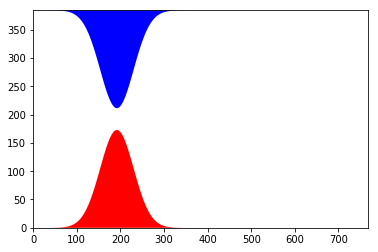

In [6]:
#Gaussian constrictions look like this. The rather small 'flat' smalles area will probably make it too unstable.
gaussian = lambda x, amp, mu, sigma:amp* ny * exp( -(x-mu)**2 / (2*sigma**2))

x = linspace(0, nx, 1000)
y = gaussian(x, 0.45, nx/4, nx/20)
y2 = ny-gaussian(x, 0.45, nx/4, nx/20)

plt.fill(x, y, 'r-', x, y2, 'b-')
plt.xlim(0, nx)
plt.ylim(0, ny)
plt.show()
plt.close()



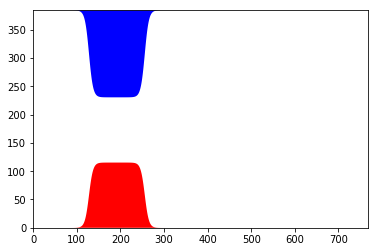

In [7]:
#tanh constriction. With the right parameters, scaled for finegraining, it has a nice flat area in the middle of the constriction
# that allows some equilibration, improving the convergence. 

def tanh_constriction(x, amp, centre, length, sharpness):
    ret = zeros(x.shape)
    
    sharpness *= 4.0/finegrain
    ret[x >= centre] = 0.5*amp* ny*(tanh(sharpness*(centre - x[x >= centre] +length/2)) + 1)
    ret[x < centre] = 0.5*amp* ny*(tanh(sharpness*(x[x < centre] + length/2  - centre)) + 1)
    return ret

x = linspace(0, nx, 1000)
y = tanh_constriction(x, 0.30, nx/4, nx/6,  0.02)
y2 = ny-tanh_constriction(x, 0.4, nx/4, nx/6, 0.02)

plt.fill(x, y, 'r-', x, y2, 'b-')
plt.xlim(0, nx)
plt.ylim(0, ny)
plt.show()
plt.close()

In [8]:
obstacle_one = fromfunction(lambda x,y: gaussian(x, 0.45, nx/4, nx/20) > y, (nx,ny))
obstacle_two = fromfunction(lambda x,y: ny-gaussian(x, 0.45, nx/4, nx/20) < y, (nx,ny))

#Gaussian pinch
obstacle_gaussian = obstacle_one + obstacle_two


obstacle_one_tanh = fromfunction(lambda x,y: tanh_constriction(x, 0.30, nx/4, nx/6, 0.02) > y, (nx,ny))
obstacle_two_tanh = fromfunction(lambda x,y: ny-tanh_constriction(x, 0.40, nx/4,nx/6, 0.02) < y, (nx,ny))
obstacle_tanh= obstacle_one_tanh+ obstacle_two_tanh

#Tanh pinch
obstacle = obstacle_tanh

#sinusoidal inflow and generic initial conditions
vel = fromfunction(lambda d,x,y: (1-d)*uLB*(1.0+1e-4*sin(y/ly*2*pi)),(2,nx,ny))
feq = equilibrium(1.0,vel)
fin = feq.copy()


In [9]:
# Code reports every 10 seconds (originally) so you don't think it died without cause.
start_time = time.time ()
report_time = start_time

# Number of iterations
for j in range(maxIter): 
    # This seems to enforce a boundary condition, likely of the type that no vertical gradient is allowed at outflow   
    fin[i1,-1,:] = fin[i1,-2,:]  
    
    # Calculate macroscopic density and velocity.
    rho = sumpop(fin)           
    u = dot(c.transpose(), fin.transpose((1,0,2)))/rho
    
     # Left wall: compute density from known populations taken from the initial velocity condition
    u[:,0,:] =vel[:,0,:]
    rho[0,:] = 1./(1.-u[0,0,:]) * (sumpop(fin[i2,0,:])+2.*sumpop(fin[i1,0,:]))

    # Left wall: Zou/He boundary condition.
    feq = equilibrium(rho,u) 
    fin[i3,0,:] = fin[i1,0,:] + feq[i3,0,:] - fin[i1,0,:]
    
    # Collision step.
    fout = fin - omega * (fin - feq)  
    for i in range(q): 
        fout[i,obstacle_tanh] = fin[noslip[i],obstacle_tanh]
    # Streaming step.
    for i in range(q): 
        fin[i,:,:] = roll(roll(fout[i,:,:],c[i,0],axis=0),c[i,1],axis=1)
 
    # How much time since last report? If greater than ten, report
    elapsed_time = time.time() - report_time
    
    if elapsed_time > 10:
        print ("Iteration %d, time spent %.3f (total %.3f)" % (j, elapsed_time, time.time() - start_time))
        report_time = time.time()
    
    # Save visual and data results
    if (j%100==0): 
        print ("Iteration %d, time spent %.3f" % (j, time.time() - start_time))
        plt.clf()
        plt.figure(dpi=1200)
        im = plt.imshow(sqrt(u[0]**2+u[1]**2).transpose(),cmap=cm.winter)
        plt.title("Iteration %d, Re=%d" % (j, Re))
        add_colorbar(im)
        plt.savefig("palabos/twosides_finegrain%d_reynolds%d_iteration%d.png" % (finegrain*100, Re, j)) 
        #plt.show()
        plt.close()  


Iteration 0, time spent 0.738
Iteration 23, time spent 10.030 (total 10.030)
Iteration 68, time spent 10.218 (total 20.248)
Iteration 100, time spent 27.762
Iteration 101, time spent 12.327 (total 32.576)
Iteration 146, time spent 10.115 (total 42.691)
Iteration 191, time spent 10.063 (total 52.754)
Iteration 200, time spent 54.633
Iteration 221, time spent 10.036 (total 62.790)
Iteration 262, time spent 10.147 (total 72.937)
Iteration 300, time spent 81.614
Iteration 301, time spent 13.624 (total 86.561)
Iteration 346, time spent 10.128 (total 96.689)
Iteration 395, time spent 10.108 (total 106.797)
Iteration 400, time spent 107.792
Iteration 427, time spent 10.196 (total 116.994)
Iteration 478, time spent 10.170 (total 127.164)
Iteration 500, time spent 131.532
Iteration 510, time spent 10.155 (total 137.319)
Iteration 561, time spent 10.126 (total 147.445)
Iteration 600, time spent 155.219
Iteration 601, time spent 11.804 (total 159.249)
Iteration 652, time spent 10.089 (total 169.3

Iteration 5606, time spent 10.032 (total 1386.641)
Iteration 5633, time spent 10.062 (total 1396.704)
Iteration 5678, time spent 10.444 (total 1407.149)
Iteration 5700, time spent 1414.037
Iteration 5701, time spent 11.865 (total 1419.014)
Iteration 5734, time spent 10.094 (total 1429.109)
Iteration 5750, time spent 10.162 (total 1439.272)
Iteration 5778, time spent 10.057 (total 1449.334)
Iteration 5800, time spent 1455.128
Iteration 5801, time spent 10.256 (total 1459.590)
Iteration 5845, time spent 10.033 (total 1469.624)
Iteration 5892, time spent 10.047 (total 1479.671)
Iteration 5900, time spent 1481.461
Iteration 5915, time spent 10.075 (total 1489.746)
Iteration 5964, time spent 10.172 (total 1499.920)
Iteration 6000, time spent 1507.623
Iteration 6001, time spent 13.898 (total 1513.818)
Iteration 6037, time spent 10.214 (total 1524.032)
Iteration 6074, time spent 10.112 (total 1534.144)
Iteration 6100, time spent 1543.641
Iteration 6101, time spent 14.314 (total 1548.458)
Iter

Iteration 10901, time spent 13.474 (total 2748.666)
Iteration 10952, time spent 10.056 (total 2758.723)
Iteration 11000, time spent 10.076 (total 2768.798)
Iteration 11000, time spent 2768.799
Iteration 11032, time spent 10.041 (total 2778.839)
Iteration 11083, time spent 10.039 (total 2788.879)
Iteration 11100, time spent 2792.228
Iteration 11115, time spent 10.040 (total 2798.919)
Iteration 11166, time spent 10.085 (total 2809.004)
Iteration 11200, time spent 2815.710
Iteration 11201, time spent 10.657 (total 2819.661)
Iteration 11252, time spent 10.053 (total 2829.714)
Iteration 11300, time spent 2839.175
Iteration 11301, time spent 13.409 (total 2843.123)
Iteration 11352, time spent 10.121 (total 2853.244)
Iteration 11400, time spent 2862.706
Iteration 11401, time spent 13.394 (total 2866.638)
Iteration 11452, time spent 10.049 (total 2876.687)
Iteration 11500, time spent 2886.147
Iteration 11501, time spent 13.416 (total 2890.103)
Iteration 11552, time spent 10.050 (total 2900.153

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in multiply
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: overflow encountered in subtract
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Iteration 13552, time spent 10.082 (total 3370.072)
Iteration 13600, time spent 3379.534
Iteration 13601, time spent 13.558 (total 3383.630)
Iteration 13652, time spent 10.085 (total 3393.715)
Iteration 13700, time spent 3403.207
Iteration 13701, time spent 13.548 (total 3407.263)
Iteration 13752, time spent 10.118 (total 3417.381)
Iteration 13800, time spent 3426.870
Iteration 13801, time spent 13.541 (total 3430.922)
Iteration 13852, time spent 10.069 (total 3440.991)
Iteration 13900, time spent 3450.545
Iteration 13901, time spent 13.623 (total 3454.614)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in multiply
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in add
  app.launch_new_instance()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in subtract
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in subtract


Iteration 13952, time spent 10.105 (total 3464.719)
Iteration 14000, time spent 3474.175
Iteration 14001, time spent 13.544 (total 3478.262)
Iteration 14052, time spent 10.045 (total 3488.308)
Iteration 14100, time spent 3497.759
Iteration 14101, time spent 13.553 (total 3501.861)
Iteration 14152, time spent 10.030 (total 3511.891)
Iteration 14200, time spent 3521.340
Iteration 14201, time spent 13.594 (total 3525.485)
Iteration 14252, time spent 10.057 (total 3535.542)
Iteration 14300, time spent 3544.995
Iteration 14301, time spent 13.750 (total 3549.292)
Iteration 14352, time spent 10.077 (total 3559.370)
Iteration 14400, time spent 3568.870
Iteration 14401, time spent 13.635 (total 3573.004)
Iteration 14452, time spent 10.051 (total 3583.056)
Iteration 14500, time spent 3592.513
Iteration 14501, time spent 13.606 (total 3596.662)
Iteration 14552, time spent 10.067 (total 3606.729)
Iteration 14600, time spent 3616.199
Iteration 14601, time spent 13.633 (total 3620.363)
Iteration 146

Iteration 19800, time spent 4853.683
Iteration 19801, time spent 13.563 (total 4857.784)
Iteration 19852, time spent 10.056 (total 4867.840)
Iteration 19900, time spent 4877.358
Iteration 19901, time spent 13.616 (total 4881.457)
Iteration 19952, time spent 10.146 (total 4891.603)
Iteration 20000, time spent 4901.074
Iteration 20001, time spent 13.557 (total 4905.161)
Iteration 20052, time spent 10.054 (total 4915.215)
Iteration 20100, time spent 4924.673
Iteration 20101, time spent 13.557 (total 4928.772)
Iteration 20152, time spent 10.048 (total 4938.820)
Iteration 20200, time spent 4948.356
Iteration 20201, time spent 13.628 (total 4952.448)
Iteration 20252, time spent 10.127 (total 4962.575)
Iteration 20300, time spent 4972.046
Iteration 20301, time spent 13.569 (total 4976.144)
Iteration 20352, time spent 10.056 (total 4986.200)
Iteration 20400, time spent 4995.655
Iteration 20401, time spent 13.538 (total 4999.737)
Iteration 20452, time spent 10.134 (total 5009.873)
Iteration 205

Iteration 25601, time spent 13.555 (total 6238.771)
Iteration 25652, time spent 10.046 (total 6248.817)
Iteration 25700, time spent 6258.260
Iteration 25701, time spent 13.536 (total 6262.353)
Iteration 25752, time spent 10.030 (total 6272.384)
Iteration 25800, time spent 6281.843
Iteration 25801, time spent 13.541 (total 6285.925)
Iteration 25852, time spent 10.048 (total 6295.973)
Iteration 25900, time spent 6305.443
Iteration 25901, time spent 13.561 (total 6309.536)
Iteration 25952, time spent 10.055 (total 6319.592)
Iteration 26000, time spent 6329.115
Iteration 26001, time spent 13.636 (total 6333.227)
Iteration 26052, time spent 10.067 (total 6343.294)
Iteration 26100, time spent 6352.745
Iteration 26101, time spent 13.534 (total 6356.829)
Iteration 26152, time spent 10.086 (total 6366.915)
Iteration 26200, time spent 6376.385
Iteration 26201, time spent 13.575 (total 6380.490)
Iteration 26252, time spent 10.078 (total 6390.568)
Iteration 26300, time spent 6400.055
Iteration 263

Iteration 31400, time spent 7612.113
Iteration 31401, time spent 13.605 (total 7616.221)
Iteration 31452, time spent 10.144 (total 7626.364)
Iteration 31500, time spent 7635.861
Iteration 31501, time spent 13.590 (total 7639.955)
Iteration 31552, time spent 10.141 (total 7650.096)
Iteration 31600, time spent 7659.635
Iteration 31601, time spent 13.632 (total 7663.728)
Iteration 31652, time spent 10.078 (total 7673.806)
Iteration 31700, time spent 7683.313
Iteration 31701, time spent 13.590 (total 7687.397)
Iteration 31752, time spent 10.087 (total 7697.484)
Iteration 31800, time spent 7706.972
Iteration 31801, time spent 13.582 (total 7711.066)
Iteration 31852, time spent 10.096 (total 7721.162)
Iteration 31900, time spent 7730.670
Iteration 31901, time spent 13.609 (total 7734.771)
Iteration 31952, time spent 10.096 (total 7744.867)
Iteration 32000, time spent 7754.401
Iteration 32001, time spent 14.036 (total 7758.902)
Iteration 32052, time spent 10.143 (total 7769.045)
Iteration 321

Iteration 37200, time spent 8992.871
Iteration 37201, time spent 13.629 (total 8996.990)
Iteration 37252, time spent 10.098 (total 9007.088)
Iteration 37300, time spent 9016.650
Iteration 37301, time spent 13.689 (total 9020.778)
Iteration 37352, time spent 10.113 (total 9030.891)
Iteration 37400, time spent 9040.405
Iteration 37401, time spent 13.720 (total 9044.610)
Iteration 37452, time spent 10.092 (total 9054.703)
Iteration 37500, time spent 9064.201
Iteration 37501, time spent 13.622 (total 9068.325)
Iteration 37552, time spent 10.101 (total 9078.426)
Iteration 37600, time spent 9087.951
Iteration 37601, time spent 13.767 (total 9092.193)
Iteration 37652, time spent 10.083 (total 9102.276)
Iteration 37700, time spent 9111.800
Iteration 37701, time spent 13.810 (total 9116.086)
Iteration 37752, time spent 10.071 (total 9126.158)
Iteration 37800, time spent 9135.650
Iteration 37801, time spent 13.608 (total 9139.766)
Iteration 37852, time spent 10.093 (total 9149.860)
Iteration 379

Iteration 43000, time spent 10377.598


MemoryError: 

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x00000190E4DCB2F0> (for post_execute):


MemoryError: 

MemoryError: 